In [3]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [4]:
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving cleaned_Mumbai Real Estate.csv to cleaned_Mumbai Real Estate.csv


In [5]:
# Shape and first 5 rows
print(f"Shape: {df.shape}")
print(df.head())

# Data types
print("\n Data Types")
print(df.dtypes)

# Missing values
print("\n Missing Values")
print(df.isnull().sum())

#  Descriptive statistics
print("\n Descriptive Statistics")
print(df.describe(include='all'))

Shape: (11376, 139)
      ID   Possession Status Availability Starts From Floor No  Commercial  \
0  12685  Under Construction                  Dec '25        5           0   
1  12684               Ready            Not Specified       20           1   
2  12683               Ready            Not Specified       18           0   
3  12682  Under Construction                  Dec '25        5           0   
4  12681  Under Construction                  Dec '24        8           1   

                               Developer Approved Authority Name  \
0                          Not Specified                    KDMC   
1  TATA Housing Development Company Ltd.                     TMC   
2                  Sai Satyam Developers                    KDMC   
3                          Birla Estates                    KDMC   
4                      Godrej Properties           Not Specified   

   Units Available      Price Price (English)  ... Meditation Area  \
0              1.0  3150000.0   

In [6]:
# Handle missing values
df['Year Available'].fillna(df['Year Available'].median(), inplace=True)
df['Units Available'].fillna(1, inplace=True)

/tmp/ipython-input-6-1492246683.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Year Available'].fillna(df['Year Available'].median(), inplace=True)
/tmp/ipython-input-6-1492246683.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [7]:
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

In [8]:
current_year = pd.Timestamp.now().year
df['Years_Until_Available'] = df['Year Available'] - current_year

In [10]:
amenities = ['Meditation Area', 'Multipurpose Courts', 'Recreational Pool',
             'Aesthetically designed landscape garden']
for amenity in amenities:
    df[amenity] = df[amenity].apply(lambda x: 1 if x > 0 else 0)

#  commercial vs residential flag
df['Property_Type'] = df['Commercial'].apply(lambda x: 'Commercial' if x == 1 else 'Residential')


In [15]:
target = 'Price'
numeric_features = ['Units Available', 'Years_Until_Available']
categorical_features = ['Possession Status', 'Developer', 'Property_Type', 'Floor No'] + amenities

In [12]:
features = numeric_features + categorical_features
X = df[features]
y = df[target]

In [19]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        random_state=42))])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train Model
model.fit(X_train, y_train)

In [21]:
# Evaluate Model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Absolute Error: 7385029.22
R-squared: 0.24


In [23]:

predictions_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
       Actual Price  Predicted Price
251       4400000.0     1.493510e+07
6071     17000000.0     1.645700e+07
6597     11500000.0     1.737086e+07
5427     14000000.0     1.619942e+07
11121    20000000.0     1.317960e+07


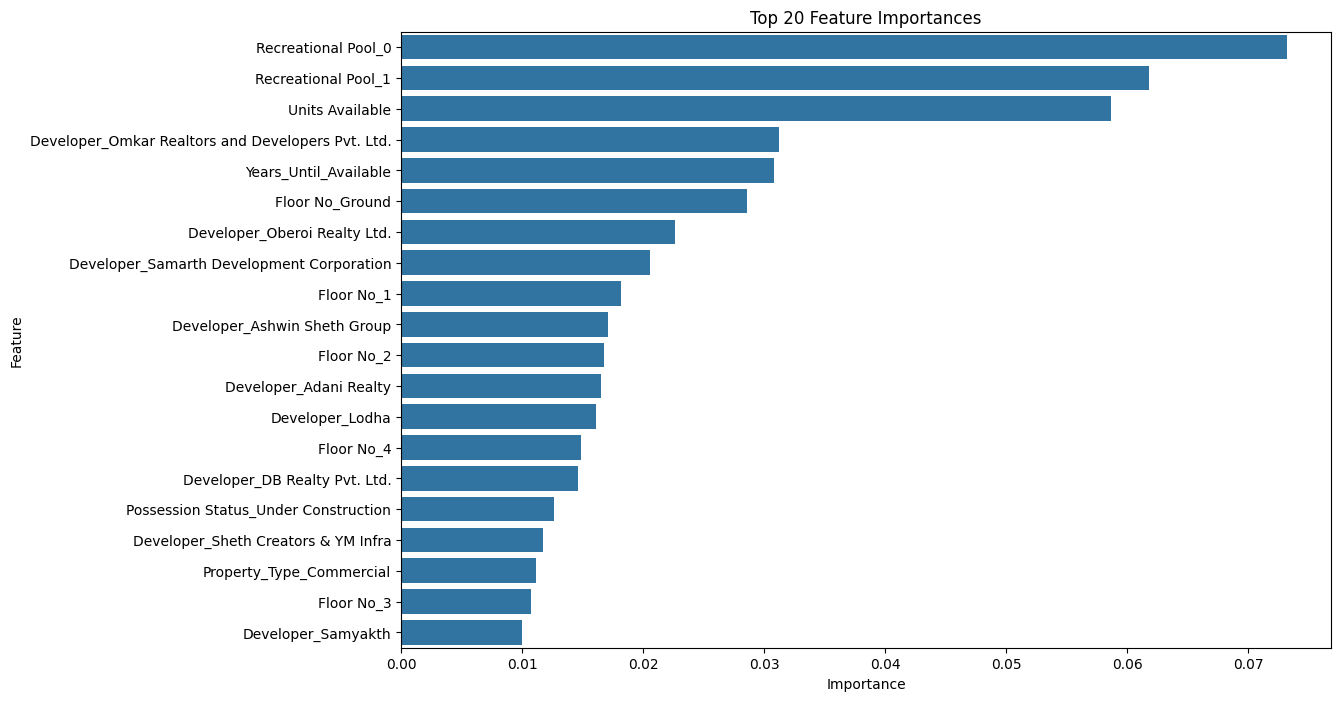

In [24]:
feature_importances = model.named_steps['regressor'].feature_importances_
cat_onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_onehot_columns])

importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 Feature Importances')
plt.show()


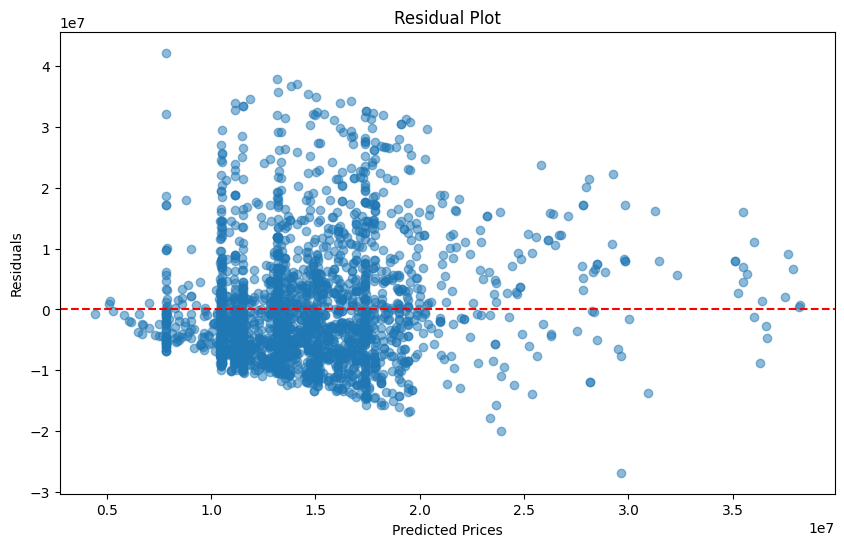

In [25]:
# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [26]:
# Save Model
import joblib
joblib.dump(model, 'real_estate_price_model.pkl')
files.download('real_estate_price_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>